# Analyzing the relation between home matches and match wins in the English Premier League (Soccer)

### Vikam Sehgal

### Introduction
Test: https://www.researchgate.net/publication/261402166_Calculating_the_Home_Advantage_in_Soccer_Leagues#:~:text=Home%2Dadvantage%20describes%20the%20benefit,%2C%202014)%20.%20...

Data: https://datahub.io/sports-data/english-premier-league

blah blah blah blahblah blah
With the premier league in full swing, discussion about home field advantage is in full swing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_set_18_19 = pd.read_csv('18_19_data.csv')
data_set_18_19.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


### Loading Data, Transforming, and Tidying
We will now transform, load, and tidy our data so as to be able to run desired operations on it.
Our dataset unfortunately doesn't provide us with an end of season table.
With the given information we can construct our own end of season table. 
We information regarding the matches - what team was the home team, what team was the away team, did the home team win or did the away team win. This is all the questions we need answered to be able to construct our table.

### Steps:
I first create a list of all the teams that are mentioned in the dataset. I iterate over all the matches held in the season and add both the home team and the away team to the "teams" list. Since each team has had multiple matches the list will contain duplicates. We can simply transform the list to a set and then back to a list to be able to store it in our end of season table dataframe.
I then create a dictionary, that stores the team name as the key and a match stat list as their value, with each index corresponding to either a win, loss, draw, home win, home goals scored, home goals conceded.
I then loop over this dictionary and add the stats to our data set.
To add points the english premier league follows a simple princple. For every match won the winning team gets 3 points, every match lost gives the team 0 points, every match that ended as a draw gives both the teams 1 point.

In [3]:
# group by teams to create columns of team, wins, loss, home wins, home goals scored, home goals conceded
def data_to_df(data_set):
    teams = []
    team_stat = {}
    for i in data_set.iterrows():
        teams.append(i[1].HomeTeam)
        teams.append(i[1].AwayTeam)
    #remove duplicates from teams
    teams = set(teams)
    for i in teams:
        team_stat[i] = [0,0,0,0,0,0,0]
    for i in data_set.iterrows():
        team_stat[i[1].HomeTeam][0]+=1
        team_stat[i[1].AwayTeam][0]+=1
        team_stat[i[1].HomeTeam][5]+=i[1].FTHG
        team_stat[i[1].HomeTeam][6]+=i[1].FTAG
        if i[1].FTHG > i[1].FTAG:
            team_stat[i[1].HomeTeam][1]+=1
            team_stat[i[1].HomeTeam][4]+=1
            team_stat[i[1].AwayTeam][2]+=1
        elif i[1].FTHG < i[1].FTAG:
            team_stat[i[1].AwayTeam][1]+=1
            team_stat[i[1].HomeTeam][2]+=1
        else:
            team_stat[i[1].HomeTeam][3]+=1
            team_stat[i[1].AwayTeam][3]+=1
    # print(team_stat)
    mp, wins, loss, draw, hw, hgs, hgc = [],[],[],[],[], [], []
    for v in team_stat:
        mp.append(team_stat[v][0])
        wins.append(team_stat[v][1])
        loss.append(team_stat[v][2])
        draw.append(team_stat[v][3])
        hw.append(team_stat[v][4])
        hgs.append(team_stat[v][5])
        hgc.append(team_stat[v][6])
    points = []
    #calculate points
    for i in range(0,len(mp)):
        points.append(wins[i]*3 + draw[i])
    epl_table = pd.DataFrame(data={'team': list(teams), 'matches_played': mp,
                                   'wins':wins, 'loss':loss,
                                   'draw':draw, 'home_win': hw,
                                  'points': points, 'home_goals': hgs,
                                  'home_goals_conceded': hgc})
    return epl_table
epl_table = data_to_df(data_set_18_19)
epl_points = epl_table.sort_values(by=['points'], ascending=False)
epl_home_games = epl_table.sort_values(by=['home_win'], ascending=False)

## Add PL TABLE 18-19  Image - Naman
# P.S. - Should we arrange data from most to recent to oldest or the other way? Tell me I will sort it out while adding these images.

In [4]:
# End of season table sorted by points.
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
11,Man City,38,32,4,2,18,98,57,12
14,Liverpool,38,30,1,7,17,97,55,10
17,Chelsea,38,21,8,9,12,72,39,12
13,Tottenham,38,23,13,2,12,71,34,16
6,Arsenal,38,21,10,7,14,70,42,16
3,Man United,38,19,10,9,10,66,33,25
7,Wolves,38,16,13,9,10,57,28,21
1,Everton,38,15,14,9,10,54,30,21
18,West Ham,38,15,16,7,9,52,32,27
9,Leicester,38,15,16,7,8,52,24,20


In [5]:
# End of season table sorted by the number of home games won
epl_home_games

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
11,Man City,38,32,4,2,18,98,57,12
14,Liverpool,38,30,1,7,17,97,55,10
6,Arsenal,38,21,10,7,14,70,42,16
17,Chelsea,38,21,8,9,12,72,39,12
13,Tottenham,38,23,13,2,12,71,34,16
1,Everton,38,15,14,9,10,54,30,21
3,Man United,38,19,10,9,10,66,33,25
7,Wolves,38,16,13,9,10,57,28,21
18,West Ham,38,15,16,7,9,52,32,27
0,Watford,38,14,16,8,8,50,26,28


### Adding Stats
Now that we have our single season table, we will add some new features
We will calculate the following:
 1. Home Win % = home_win / home matches_played (19)
 2. Total Win % = wins / matches_played

In [6]:
epl_points['home_win%'] = epl_points['home_win']/19
epl_points['total_win%'] = epl_points['wins']/epl_points['matches_played']
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
11,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105
14,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474
17,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632
13,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263
6,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632
3,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000
7,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053
1,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737
18,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737
9,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737


To get an idea of what advantage a home game gives we add the 'home_advantage' feature.
Home advantage in the english premier league is calculated as follows:
 Home Advantage = (Home Goals Scored - Home Goals Conceded) / 19

source: https://www.pinnacle.com/en/betting-articles/Soccer/Home-Field-Advantage/FGU2ZXMPGZCTFHSE

In [7]:
epl_points['home_advantage'] = (epl_points['home_goals'] - epl_points['home_goals_conceded']) /19
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
11,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105,2.368421
14,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474,2.368421
17,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632,1.421053
13,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263,0.947368
6,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632,1.368421
3,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000,0.421053
7,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053,0.368421
1,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737,0.473684
18,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737,0.263158
9,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737,0.210526


### Plot for season 18-19
We now visualize the home advantage and the home_win% by plotting scatter plots.
Here the x axis is the team, and y axis is the home advantage and home_win%.

These plots give us a rough visual idea of the home advantage and home_win% over the season.

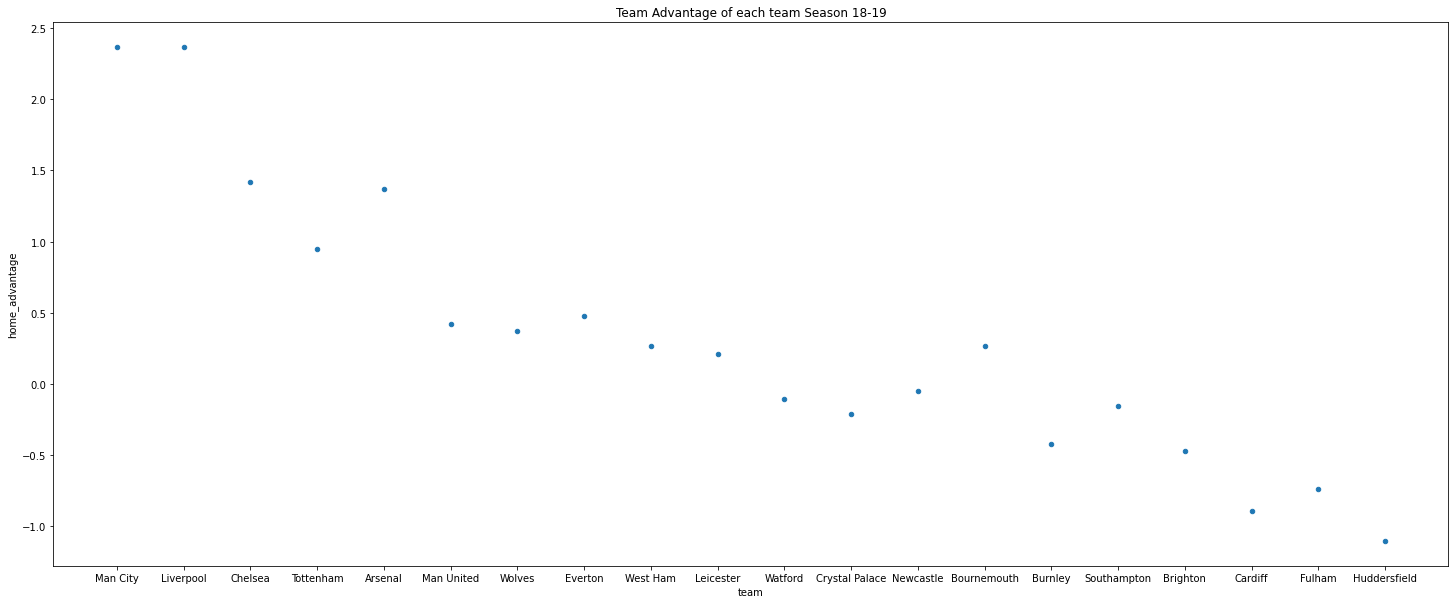

In [8]:
epl_points.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 18-19',
               figsize=(25,10))

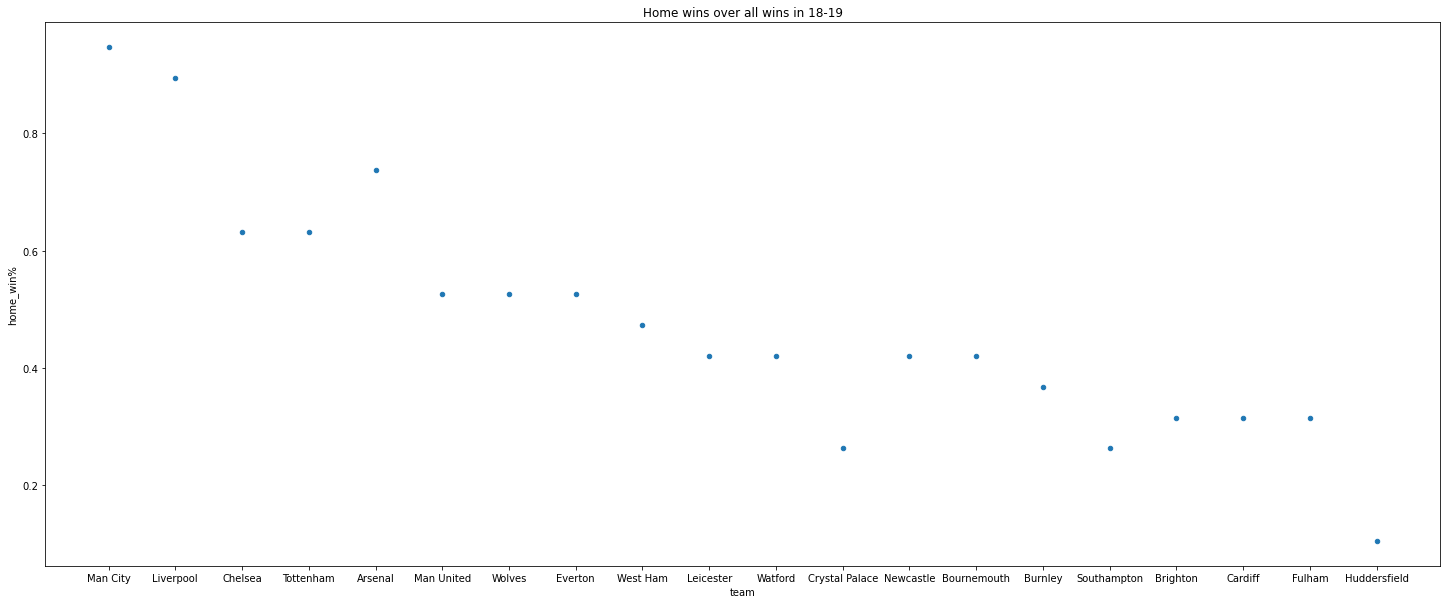

In [9]:
epl_points.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 18-19',
               figsize=(25,10))

### Observation:
some observation here.....

Let us look at the data from past 5 seasons to get a better idea

In [10]:
# Load data from other 4 seasons: 14-15, 15-16, 16-17, 17-18
epl_table1415 = data_to_df(pd.read_csv('14_15_data.csv'))
epl_table1516 = data_to_df(pd.read_csv('15_16_data.csv'))
epl_table1617 = data_to_df(pd.read_csv('16_17_data.csv'))
epl_table1718 = data_to_df(pd.read_csv('17_18_data.csv'))

## Naman

In [11]:
epl_table1819 = epl_points

In [12]:
epl_table1819

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
11,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105,2.368421
14,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474,2.368421
17,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632,1.421053
13,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263,0.947368
6,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632,1.368421
3,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000,0.421053
7,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053,0.368421
1,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737,0.473684
18,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737,0.263158
9,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737,0.210526


In [13]:
epl_table1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
0,Watford,38,11,19,8,7,41,27,31
1,Stoke,38,7,19,12,5,33,20,30
2,Everton,38,13,15,10,10,49,28,22
3,Huddersfield,38,9,19,10,6,37,16,25
4,Bournemouth,38,11,16,11,7,44,26,30
5,Man United,38,25,7,6,15,81,38,9
6,Swansea,38,8,21,9,6,33,17,24
7,Arsenal,38,19,13,6,15,63,54,20
8,Crystal Palace,38,11,16,11,7,44,29,27
9,Leicester,38,12,15,11,7,47,25,22


In [14]:
epl_points1718 = epl_table1718.sort_values(by=['points'], ascending=False)

## ADD PL TABLE 17-18 IMAGE - NAMAN

In [15]:
epl_points1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
11,Man City,38,32,2,4,16,100,61,14
5,Man United,38,25,7,6,15,81,38,9
13,Tottenham,38,23,7,8,13,77,40,16
14,Liverpool,38,21,5,12,12,75,45,10
18,Chelsea,38,21,10,7,11,70,30,16
7,Arsenal,38,19,13,6,15,63,54,20
16,Burnley,38,14,12,12,7,54,16,17
2,Everton,38,13,15,10,10,49,28,22
9,Leicester,38,12,15,11,7,47,25,22
10,Newcastle,38,12,18,8,8,44,21,17


In [16]:
epl_home_games1718 = epl_table1718.sort_values(by=['home_win'], ascending=False)

In [17]:
epl_home_games1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
11,Man City,38,32,2,4,16,100,61,14
5,Man United,38,25,7,6,15,81,38,9
7,Arsenal,38,19,13,6,15,63,54,20
13,Tottenham,38,23,7,8,13,77,40,16
14,Liverpool,38,21,5,12,12,75,45,10
18,Chelsea,38,21,10,7,11,70,30,16
2,Everton,38,13,15,10,10,49,28,22
10,Newcastle,38,12,18,8,8,44,21,17
16,Burnley,38,14,12,12,7,54,16,17
12,Brighton,38,9,16,13,7,40,24,25


In [18]:
epl_points1718['home_win%'] = epl_points1718['home_win']/19
epl_points1718['total_win%'] = epl_points1718['wins']/epl_points1718['matches_played']
epl_points1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
11,Man City,38,32,2,4,16,100,61,14,0.842105,0.842105
5,Man United,38,25,7,6,15,81,38,9,0.789474,0.657895
13,Tottenham,38,23,7,8,13,77,40,16,0.684211,0.605263
14,Liverpool,38,21,5,12,12,75,45,10,0.631579,0.552632
18,Chelsea,38,21,10,7,11,70,30,16,0.578947,0.552632
7,Arsenal,38,19,13,6,15,63,54,20,0.789474,0.500000
16,Burnley,38,14,12,12,7,54,16,17,0.368421,0.368421
2,Everton,38,13,15,10,10,49,28,22,0.526316,0.342105
9,Leicester,38,12,15,11,7,47,25,22,0.368421,0.315789
10,Newcastle,38,12,18,8,8,44,21,17,0.421053,0.315789


In [19]:
epl_points1718['home_advantage'] = (epl_points1718['home_goals'] - epl_points1718['home_goals_conceded']) /19
epl_points1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
11,Man City,38,32,2,4,16,100,61,14,0.842105,0.842105,2.473684
5,Man United,38,25,7,6,15,81,38,9,0.789474,0.657895,1.526316
13,Tottenham,38,23,7,8,13,77,40,16,0.684211,0.605263,1.263158
14,Liverpool,38,21,5,12,12,75,45,10,0.631579,0.552632,1.842105
18,Chelsea,38,21,10,7,11,70,30,16,0.578947,0.552632,0.736842
7,Arsenal,38,19,13,6,15,63,54,20,0.789474,0.500000,1.789474
16,Burnley,38,14,12,12,7,54,16,17,0.368421,0.368421,-0.052632
2,Everton,38,13,15,10,10,49,28,22,0.526316,0.342105,0.315789
9,Leicester,38,12,15,11,7,47,25,22,0.368421,0.315789,0.157895
10,Newcastle,38,12,18,8,8,44,21,17,0.421053,0.315789,0.210526


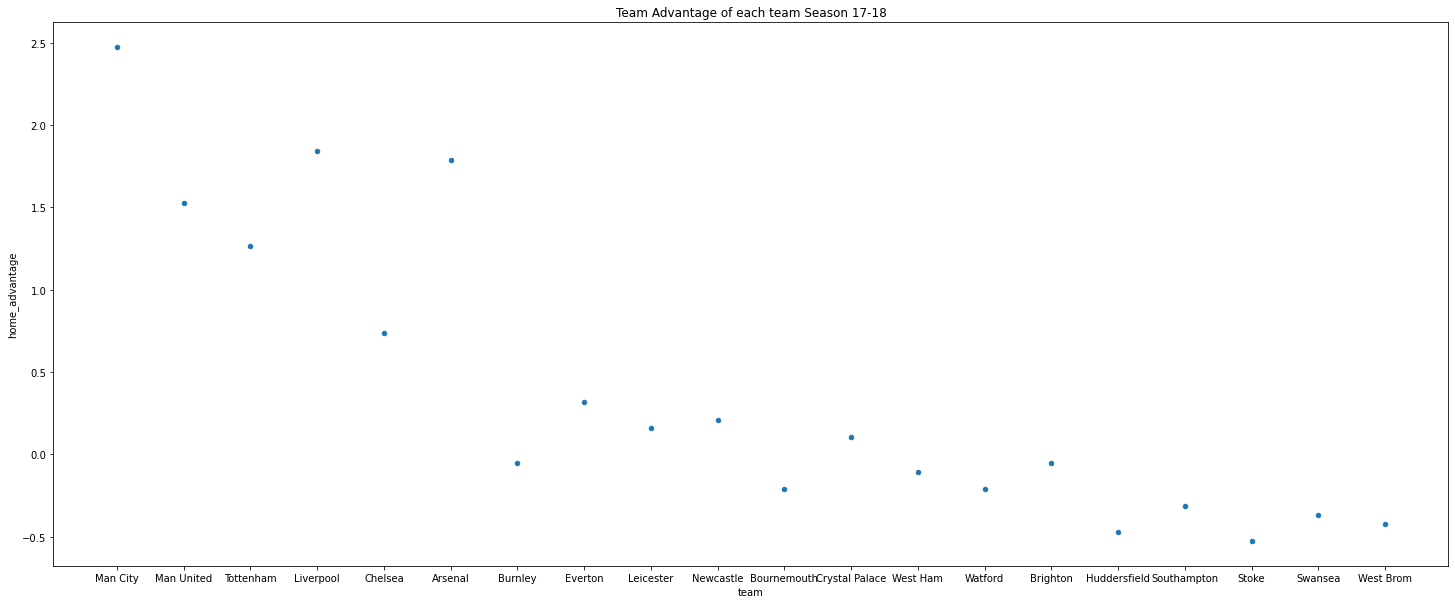

In [20]:
epl_points1718.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 17-18',
               figsize=(25,10))

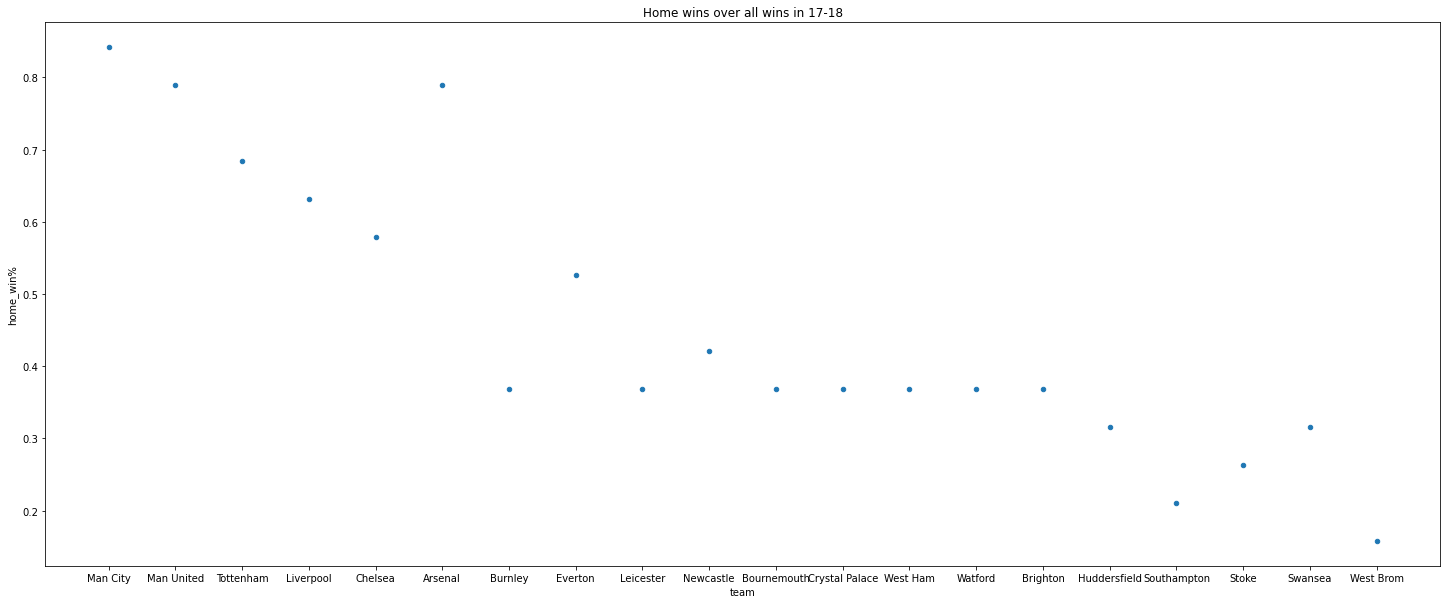

In [21]:
epl_points1718.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 17-18',
               figsize=(25,10))

In [22]:
epl_points1617 = epl_table1617.sort_values(by=['points'], ascending=False)

## Insert PL Table 16-17 Image - NAMAN

In [23]:
epl_points1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
18,Chelsea,38,30,5,3,17,93,55,17
12,Tottenham,38,26,4,8,17,86,47,9
10,Man City,38,23,6,9,11,78,37,17
13,Liverpool,38,22,6,10,12,76,45,18
7,Arsenal,38,23,9,6,14,75,39,16
5,Man United,38,18,5,15,8,69,26,12
2,Everton,38,17,11,10,13,61,42,16
4,Bournemouth,38,12,16,10,9,46,35,29
15,Southampton,38,12,16,10,6,46,17,21
17,West Brom,38,12,17,9,9,45,27,22


In [24]:
epl_home_games1617 = epl_table1617.sort_values(by=['home_win'], ascending=False)

In [25]:
epl_home_games1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
18,Chelsea,38,30,5,3,17,93,55,17
12,Tottenham,38,26,4,8,17,86,47,9
7,Arsenal,38,23,9,6,14,75,39,16
2,Everton,38,17,11,10,13,61,42,16
13,Liverpool,38,22,6,10,12,76,45,18
10,Man City,38,23,6,9,11,78,37,17
16,Burnley,38,11,20,7,10,40,26,20
9,Leicester,38,12,18,8,10,44,31,25
4,Bournemouth,38,12,16,10,9,46,35,29
17,West Brom,38,12,17,9,9,45,27,22


In [26]:
epl_points1617['home_win%'] = epl_points1617['home_win']/19
epl_points1617['total_win%'] = epl_points1617['wins']/epl_points1617['matches_played']
epl_points1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
18,Chelsea,38,30,5,3,17,93,55,17,0.894737,0.789474
12,Tottenham,38,26,4,8,17,86,47,9,0.894737,0.684211
10,Man City,38,23,6,9,11,78,37,17,0.578947,0.605263
13,Liverpool,38,22,6,10,12,76,45,18,0.631579,0.578947
7,Arsenal,38,23,9,6,14,75,39,16,0.736842,0.605263
5,Man United,38,18,5,15,8,69,26,12,0.421053,0.473684
2,Everton,38,17,11,10,13,61,42,16,0.684211,0.447368
4,Bournemouth,38,12,16,10,9,46,35,29,0.473684,0.315789
15,Southampton,38,12,16,10,6,46,17,21,0.315789,0.315789
17,West Brom,38,12,17,9,9,45,27,22,0.473684,0.315789


In [27]:
epl_points1617['home_advantage'] = (epl_points1617['home_goals'] - epl_points1617['home_goals_conceded']) /19
epl_points1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
18,Chelsea,38,30,5,3,17,93,55,17,0.894737,0.789474,2.000000
12,Tottenham,38,26,4,8,17,86,47,9,0.894737,0.684211,2.000000
10,Man City,38,23,6,9,11,78,37,17,0.578947,0.605263,1.052632
13,Liverpool,38,22,6,10,12,76,45,18,0.631579,0.578947,1.421053
7,Arsenal,38,23,9,6,14,75,39,16,0.736842,0.605263,1.210526
5,Man United,38,18,5,15,8,69,26,12,0.421053,0.473684,0.736842
2,Everton,38,17,11,10,13,61,42,16,0.684211,0.447368,1.368421
4,Bournemouth,38,12,16,10,9,46,35,29,0.473684,0.315789,0.315789
15,Southampton,38,12,16,10,6,46,17,21,0.315789,0.315789,-0.210526
17,West Brom,38,12,17,9,9,45,27,22,0.473684,0.315789,0.263158


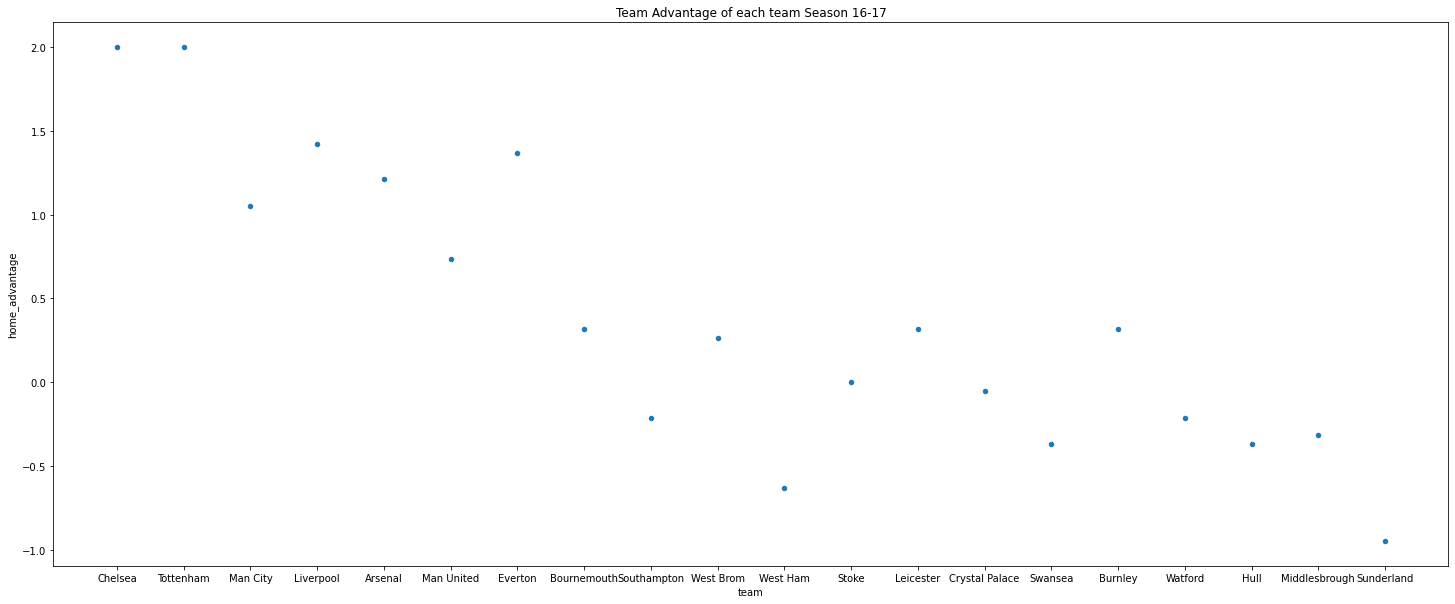

In [28]:
epl_points1617.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 16-17',
               figsize=(25,10))

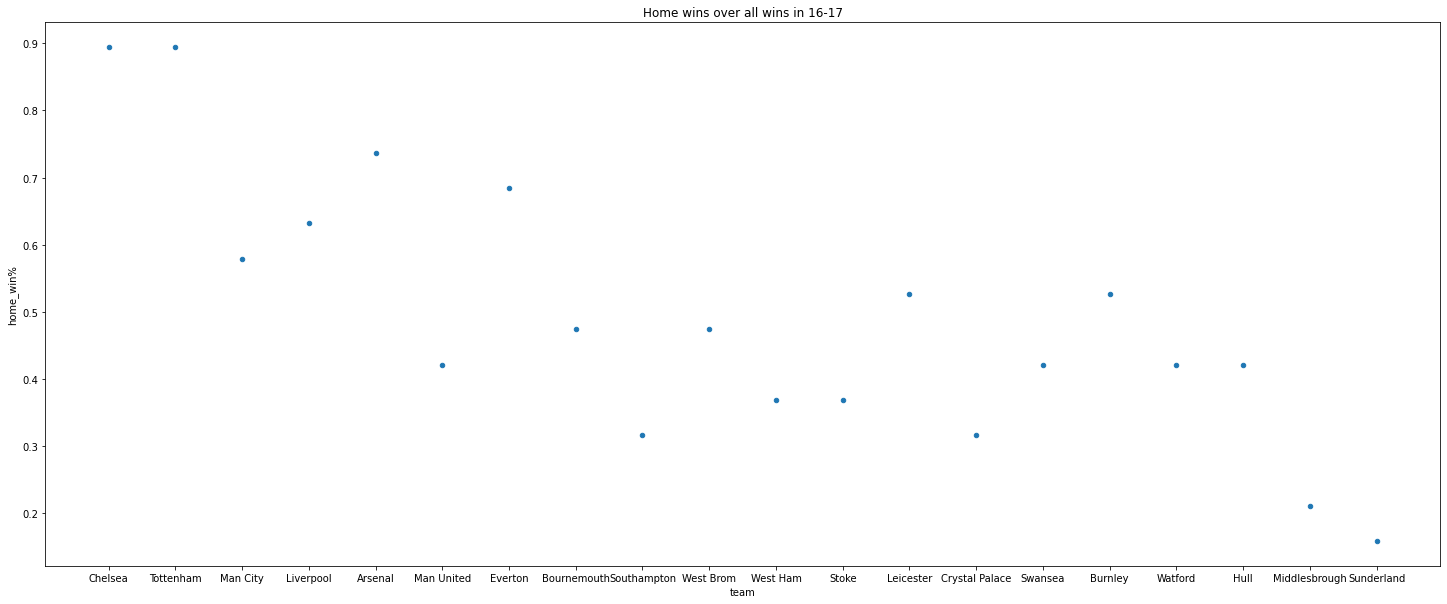

In [29]:
epl_points1617.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 16-17',
               figsize=(25,10))

In [30]:
epl_points1516 = epl_table1516.sort_values(by=['points'], ascending=False)

## Insert PL Table 15-16 Image - Naman

In [31]:
epl_points1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
9,Leicester,38,23,3,12,12,81,35,18
6,Arsenal,38,20,7,11,12,71,31,11
12,Tottenham,38,19,6,13,10,70,35,15
4,Man United,38,19,10,9,12,66,27,9
11,Man City,38,19,10,9,12,66,47,21
15,Southampton,38,18,11,9,11,63,39,22
19,West Ham,38,16,8,14,9,62,34,26
13,Liverpool,38,16,10,12,8,60,33,22
1,Stoke,38,14,15,9,8,51,22,24
18,Chelsea,38,12,12,14,5,50,32,30


In [32]:
epl_home_games1516 = epl_table1516.sort_values(by=['home_win'], ascending=False)

In [33]:
epl_home_games1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
4,Man United,38,19,10,9,12,66,27,9
6,Arsenal,38,20,7,11,12,71,31,11
11,Man City,38,19,10,9,12,66,47,21
9,Leicester,38,23,3,12,12,81,35,18
15,Southampton,38,18,11,9,11,63,39,22
12,Tottenham,38,19,6,13,10,70,35,15
19,West Ham,38,16,8,14,9,62,34,26
1,Stoke,38,14,15,9,8,51,22,24
13,Liverpool,38,16,10,12,8,60,33,22
5,Swansea,38,12,15,11,8,47,20,20


In [34]:
epl_points1516['home_win%'] = epl_points1516['home_win']/19
epl_points1516['total_win%'] = epl_points1516['wins']/epl_points1516['matches_played']
epl_points1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
9,Leicester,38,23,3,12,12,81,35,18,0.631579,0.605263
6,Arsenal,38,20,7,11,12,71,31,11,0.631579,0.526316
12,Tottenham,38,19,6,13,10,70,35,15,0.526316,0.500000
4,Man United,38,19,10,9,12,66,27,9,0.631579,0.500000
11,Man City,38,19,10,9,12,66,47,21,0.631579,0.500000
15,Southampton,38,18,11,9,11,63,39,22,0.578947,0.473684
19,West Ham,38,16,8,14,9,62,34,26,0.473684,0.421053
13,Liverpool,38,16,10,12,8,60,33,22,0.421053,0.421053
1,Stoke,38,14,15,9,8,51,22,24,0.421053,0.368421
18,Chelsea,38,12,12,14,5,50,32,30,0.263158,0.315789


In [35]:
epl_points1516['home_advantage'] = (epl_points1516['home_goals'] - epl_points1516['home_goals_conceded']) /19
epl_points1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
9,Leicester,38,23,3,12,12,81,35,18,0.631579,0.605263,0.894737
6,Arsenal,38,20,7,11,12,71,31,11,0.631579,0.526316,1.052632
12,Tottenham,38,19,6,13,10,70,35,15,0.526316,0.500000,1.052632
4,Man United,38,19,10,9,12,66,27,9,0.631579,0.500000,0.947368
11,Man City,38,19,10,9,12,66,47,21,0.631579,0.500000,1.368421
15,Southampton,38,18,11,9,11,63,39,22,0.578947,0.473684,0.894737
19,West Ham,38,16,8,14,9,62,34,26,0.473684,0.421053,0.421053
13,Liverpool,38,16,10,12,8,60,33,22,0.421053,0.421053,0.578947
1,Stoke,38,14,15,9,8,51,22,24,0.421053,0.368421,-0.105263
18,Chelsea,38,12,12,14,5,50,32,30,0.263158,0.315789,0.105263


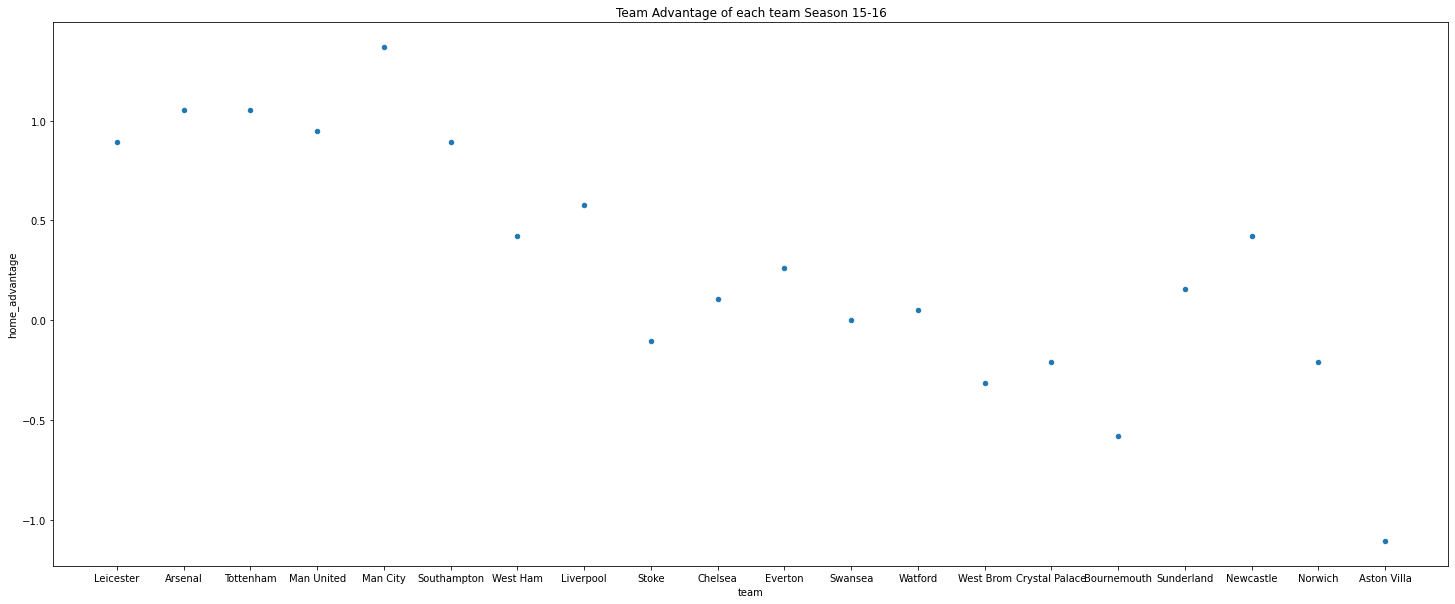

In [36]:
epl_points1516.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 15-16',
               figsize=(25,10))

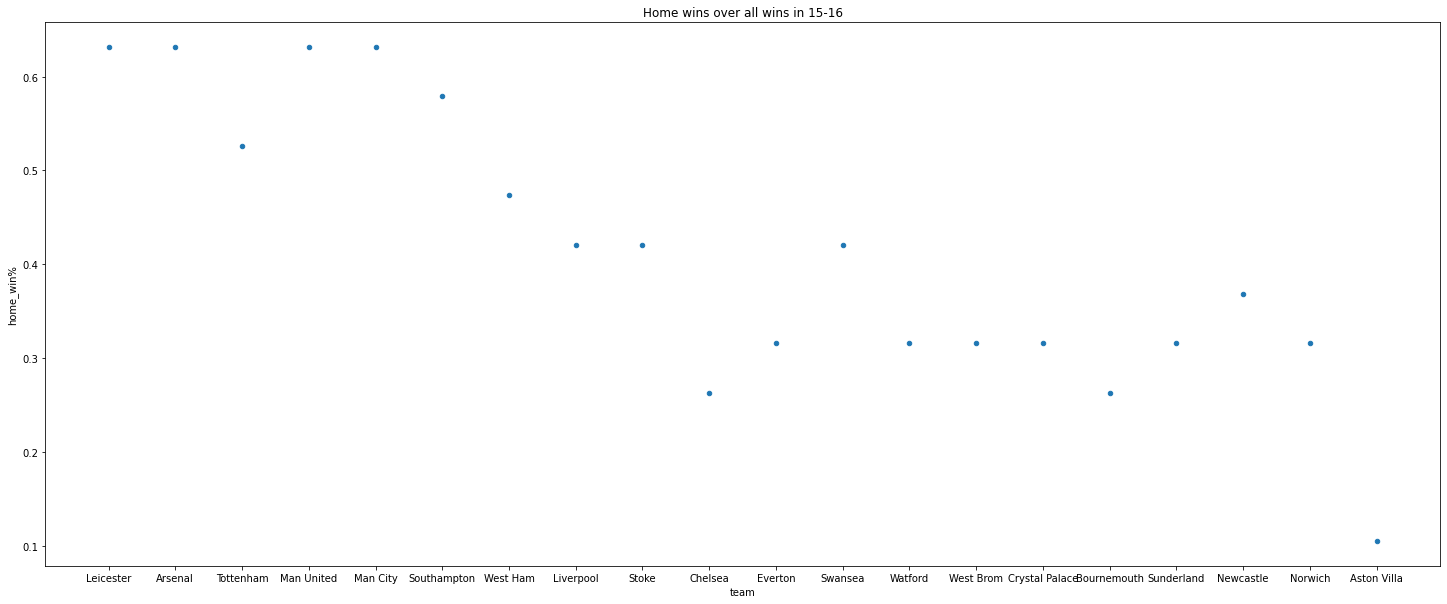

In [37]:
epl_points1516.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 15-16',
               figsize=(25,10))

In [38]:
epl_points1415 = epl_table1415.sort_values(by=['points'], ascending=False)

## Insert PL Table Image 14-15

In [46]:
epl_points1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
18,Chelsea,38,26,3,9,15,87,36,9,0.789474,0.684211,1.421053
9,Man City,38,24,7,7,14,79,44,14,0.736842,0.631579,1.578947
4,Arsenal,38,22,7,9,12,75,41,14,0.631579,0.578947,1.421053
2,Man United,38,20,8,10,14,70,41,15,0.736842,0.526316,1.368421
11,Tottenham,38,19,12,7,10,64,31,24,0.526316,0.500000,0.368421
12,Liverpool,38,18,12,8,10,62,30,20,0.526316,0.473684,0.526316
14,Southampton,38,18,14,6,11,60,37,13,0.578947,0.473684,1.263158
3,Swansea,38,16,14,8,9,56,27,22,0.473684,0.421053,0.263158
0,Stoke,38,15,14,9,10,54,32,22,0.526316,0.394737,0.526316
6,Crystal Palace,38,13,16,9,6,48,21,27,0.315789,0.342105,-0.315789


In [40]:
epl_home_games1415 = epl_table1415.sort_values(by=['home_win'], ascending=False)

In [41]:
epl_home_games1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
18,Chelsea,38,26,3,9,15,87,36,9
9,Man City,38,24,7,7,14,79,44,14
2,Man United,38,20,8,10,14,70,41,15
4,Arsenal,38,22,7,9,12,75,41,14
14,Southampton,38,18,14,6,11,60,37,13
0,Stoke,38,15,14,9,10,54,32,22
12,Liverpool,38,18,12,8,10,62,30,20
11,Tottenham,38,19,12,7,10,64,31,24
19,West Ham,38,12,15,11,9,47,25,18
3,Swansea,38,16,14,8,9,56,27,22


In [42]:
epl_points1415['home_win%'] = epl_points1415['home_win']/19
epl_points1415['total_win%'] = epl_points1415['wins']/epl_points1516['matches_played']
epl_points1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
18,Chelsea,38,26,3,9,15,87,36,9,0.789474,0.684211
9,Man City,38,24,7,7,14,79,44,14,0.736842,0.631579
4,Arsenal,38,22,7,9,12,75,41,14,0.631579,0.578947
2,Man United,38,20,8,10,14,70,41,15,0.736842,0.526316
11,Tottenham,38,19,12,7,10,64,31,24,0.526316,0.500000
12,Liverpool,38,18,12,8,10,62,30,20,0.526316,0.473684
14,Southampton,38,18,14,6,11,60,37,13,0.578947,0.473684
3,Swansea,38,16,14,8,9,56,27,22,0.473684,0.421053
0,Stoke,38,15,14,9,10,54,32,22,0.526316,0.394737
6,Crystal Palace,38,13,16,9,6,48,21,27,0.315789,0.342105


In [43]:
epl_points1415['home_advantage'] = (epl_points1415['home_goals'] - epl_points1415['home_goals_conceded']) /19
epl_points1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
18,Chelsea,38,26,3,9,15,87,36,9,0.789474,0.684211,1.421053
9,Man City,38,24,7,7,14,79,44,14,0.736842,0.631579,1.578947
4,Arsenal,38,22,7,9,12,75,41,14,0.631579,0.578947,1.421053
2,Man United,38,20,8,10,14,70,41,15,0.736842,0.526316,1.368421
11,Tottenham,38,19,12,7,10,64,31,24,0.526316,0.500000,0.368421
12,Liverpool,38,18,12,8,10,62,30,20,0.526316,0.473684,0.526316
14,Southampton,38,18,14,6,11,60,37,13,0.578947,0.473684,1.263158
3,Swansea,38,16,14,8,9,56,27,22,0.473684,0.421053,0.263158
0,Stoke,38,15,14,9,10,54,32,22,0.526316,0.394737,0.526316
6,Crystal Palace,38,13,16,9,6,48,21,27,0.315789,0.342105,-0.315789


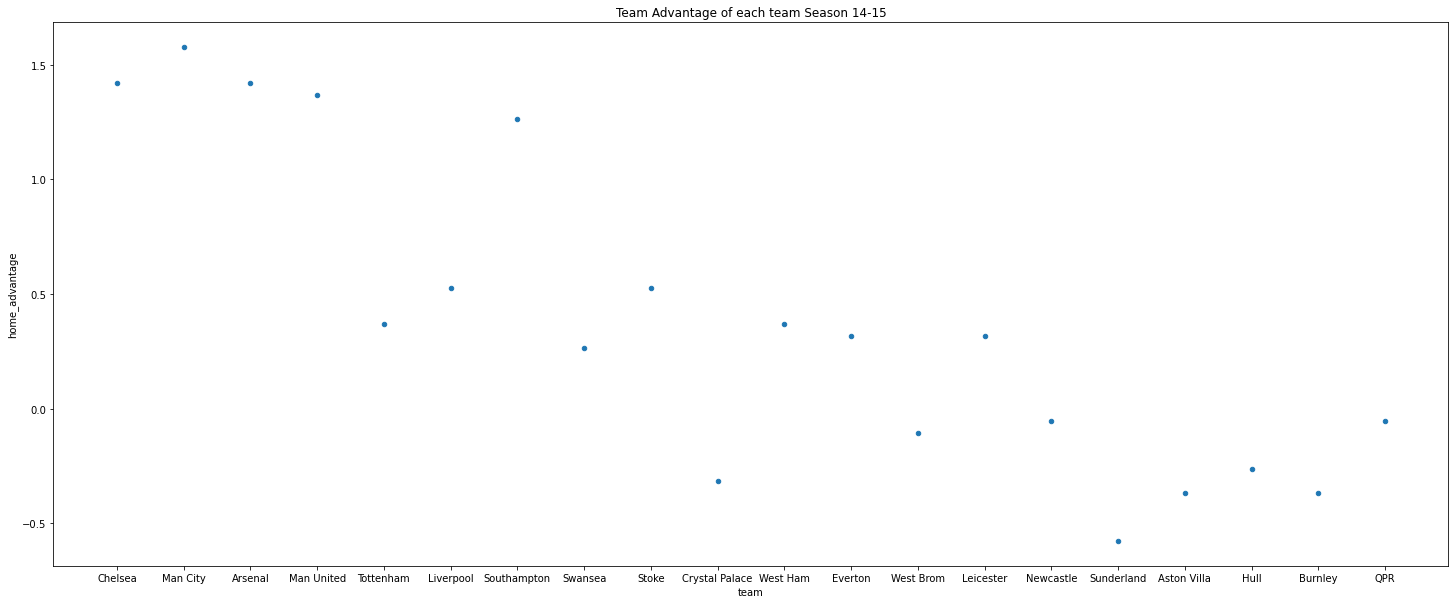

In [44]:
epl_points1415.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 14-15',
               figsize=(25,10))

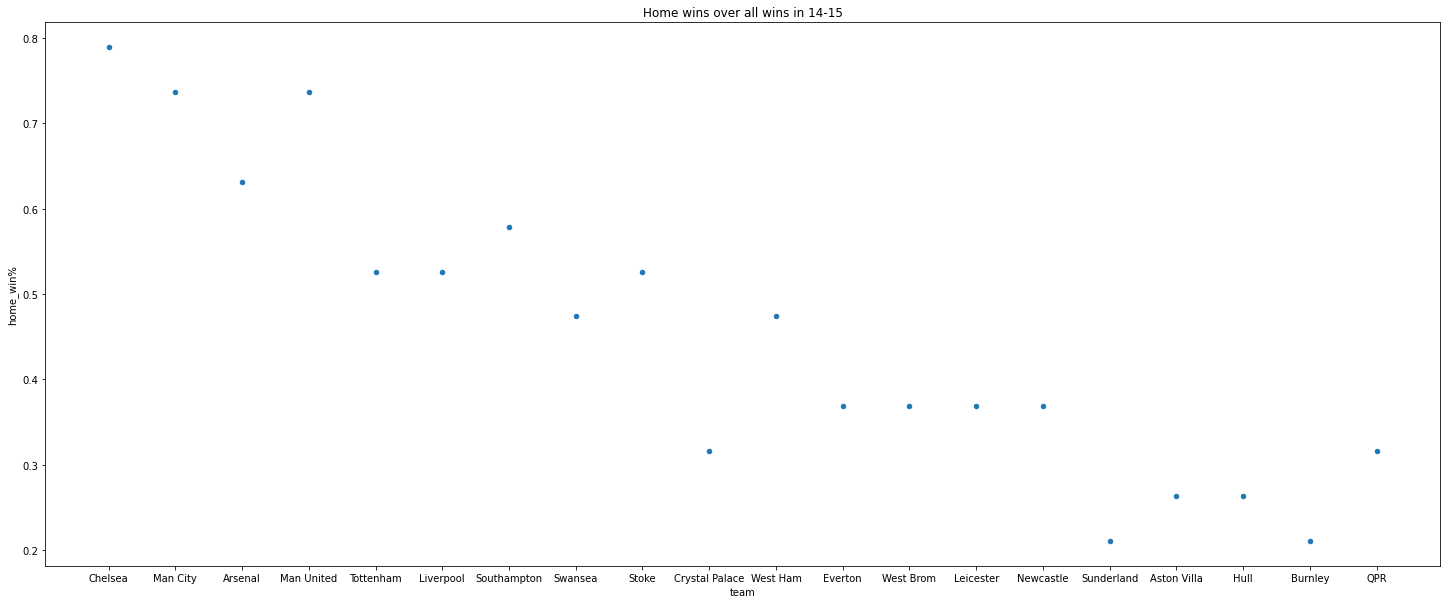

In [45]:
epl_points1415.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 14-15',
               figsize=(25,10))